In [1]:
import pandas as pd
import numpy as np
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

input_data_ordered_raw =  pd.read_csv('rnap_scanned_over_ecoli_genome200k.csv')
sequences = input_data_ordered_raw['seq'].tolist()

In [2]:
input_data_ordered_raw.head()

,Unnamed: 0,val,seq,left,right,ori,contig
0,0,23.9083,CTATTACCTGCCCACGGTAAAGGCGTTCTGGTTGCCCTACG,3695629,3695669,+,MG1655.fa
1,1,23.5831,TTTCTGCCCGCGGCCTGGCAATTGATACCGCCTTGCCATCG,1109059,1109099,+,MG1655.fa
2,2,23.4205,TTTTTACACGCCTTGCGTAAAGCGGCACGGCGCGGGGTGCG,822216,822256,-,MG1655.fa
3,3,23.4098,TTGCTGCCTGGCCGATGGTCTATGCCGCTGCGTTCTCCGGC,772478,772518,+,MG1655.fa
4,4,23.3640,CTTTTACACGCAAAATGCCGTCACGTTCACGGGTCTGGGCT,2748531,2748571,+,MG1655.fa


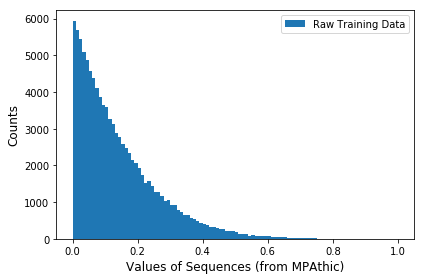

In [3]:
unbalanced_pos_labels = np.array(input_data_ordered_raw['val'][0:100000])
unbalanced_pos_labels = (unbalanced_pos_labels-min(unbalanced_pos_labels))/(max(unbalanced_pos_labels)-min(unbalanced_pos_labels))

plt.hist(unbalanced_pos_labels,bins=100,label='Raw Training Data')
plt.legend()
plt.ylabel('Counts',fontsize=12)
plt.xlabel('Values of Sequences (from MPAthic)',fontsize=12)
#plt.title('Convolutional Neural Network Performance')
plt.tight_layout()
#
#plt.savefig('Write_up/raw_data_histogram.png')
plt.show()



## Randomly sample vals and seqs to prevent data imbalance

In [4]:
input_data_ordered_raw[['val','seq']].head()

,val,seq
0,23.9083,CTATTACCTGCCCACGGTAAAGGCGTTCTGGTTGCCCTACG
1,23.5831,TTTCTGCCCGCGGCCTGGCAATTGATACCGCCTTGCCATCG
2,23.4205,TTTTTACACGCCTTGCGTAAAGCGGCACGGCGCGGGGTGCG
3,23.4098,TTGCTGCCTGGCCGATGGTCTATGCCGCTGCGTTCTCCGGC
4,23.3640,CTTTTACACGCAAAATGCCGTCACGTTCACGGGTCTGGGCT


In [5]:
# normally sample high value seqs more
# https://stackoverflow.com/questions/33160367/numpy-how-to-generate-a-normally-distributed-set-of-integers
bi = np.random.binomial(n=10000, p=0.01, size=1000)


In [6]:
num_sample = 50000   # number of training samples
test_size = 10000    # number of test samples

binomial_probability_parameter = 0.5

#index_random_sample_training_data = np.random.randint(100000,size=(9000))
index_random_sample_training_data = np.random.binomial(n=200000, p=binomial_probability_parameter, size=num_sample)

#index_random_sample_training_data = set(index_random_sample_training_data)
#index_random_sample_training_data = list(index_random_sample_training_data)

input_data_raw = input_data_ordered_raw[['val','seq']].loc[index_random_sample_training_data]
print(input_data_raw.head())

#index_random_sample_test_data = np.random.randint(100000,size=(1000))
index_random_sample_test_data = np.random.binomial(n=200000, p=binomial_probability_parameter, size=test_size)

#index_random_sample_test_data = set(index_random_sample_test_data)
#index_random_sample_test_data = list(index_random_sample_test_data)

input_data_raw_test = input_data_ordered_raw[['val','seq']].loc[index_random_sample_test_data]

print(input_data_raw_test.head())

            val                                        seq
99965   19.7456  CATCAACACGGCAATGACTTCACGTTTACTGCTGGATCTGA
100009  19.7453  CTCGCCCATTCCGACGATCTGGTGAACAGGCAGAGTGCCGG
100055  19.7450  TTTCGGCATGGCTTCGGTGCGTTTTATTTGCGGCACTCAGG
99880   19.7464  GATCTGGCTAACCGCTATGTCGATGAACAGGCTCCGTGGGT
100011  19.7453  GCTGAAAACGCTCAATGAGAAGAGTAACGCGCTGGTATTTG
            val                                        seq
100092  19.7447  TTATTCCCAGGCTCTGTGTGACTACGCCGGAGGTCTCACCG
99640   19.7480  CAGGAGAATGCCAGCGCAATCATTACCCGCTGGCGCATACC
100446  19.7421  GTTCCGCACACTATCGGCAACCCGTTATACCACTGGACGCA
100202  19.7440  TGGTTCCCGACGAAAGAACGTGGTACTGCCTCCGCCATCTT
99908   19.7461  TTTATGCCGAACGCGCCCGTCACGGCGTGGCGCTGATTGTC


In [7]:
#from random import shuffle
#shuffle(index_random_sample_training_data)
#shuffle(index_random_sample_test_data)

In [8]:
#num_sample = len(set(index_random_sample_training_data))
#test_size = len(set(index_random_sample_test_data))

## Ensure no test data got into training dataset

In [9]:
separate_test_from_train = input_data_raw_test[['val','seq']].merge(input_data_raw[['val','seq']], how = "left")
separate_test_from_train = separate_test_from_train.drop_duplicates()

input_data_raw_test = separate_test_from_train

In [10]:
test_size = len(input_data_raw_test)
print(test_size)

1154


## Make positive and negative Labels

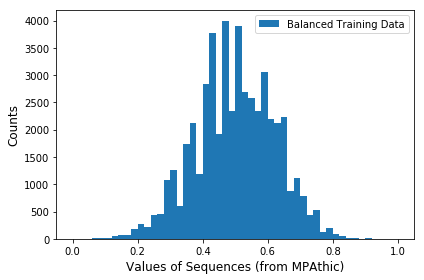

In [11]:
# positive and negative labels
# normalize the following between 0 and 1
pos_labels = np.array(input_data_raw['val'][0:num_sample])
pos_labels = (pos_labels-min(pos_labels))/(max(pos_labels)-min(pos_labels))

# test positive and negative labels
test_pos_labels = np.array(input_data_raw_test['val'][0:test_size])
test_pos_labels = (test_pos_labels-min(test_pos_labels))/(max(test_pos_labels)-min(test_pos_labels))

plt.hist(pos_labels,bins=50,label='Balanced Training Data')
plt.legend()

plt.ylabel('Counts',fontsize=12)
plt.xlabel('Values of Sequences (from MPAthic)',fontsize=12)
plt.tight_layout()
#plt.savefig('Write_up/balanced_training_histogram.png')
plt.show()
# assigned random values to negative examples

In [12]:
sequences = np.array(sequences)

pos = []
pos = list(sequences[index_random_sample_training_data])

test_pos = []
#test_pos = list(sequences[index_random_sample_test_data])
test_pos = list(input_data_raw_test['seq'])

pos = np.array(pos)
test_pos = np.array(test_pos)

seq_length = len(pos[0])

## One-hot encoding

In [13]:
temp_pos = []
temp_pos_test = []
for reshape_index in range(len(pos)):
    temp_pos.append(list(pos[reshape_index]))

for reshape_test_index in range(len(test_pos)):
    temp_pos_test.append(list(test_pos[reshape_test_index]))
    
pos = temp_pos
test_pos = temp_pos_test

In [14]:
pos = np.array(pos)
test_pos = np.array(test_pos)

In [15]:
pos_tensor = np.zeros(list(pos.shape) + [4])

test_pos_tensor = np.zeros(list(test_pos.shape) + [4])

base_dict = {'A': 0, 'C': 1, 'G': 2, 'T': 3}

#naive one-hot encoding
for row in range(num_sample):
    for col in range(seq_length):
        pos_tensor[row,col,base_dict[pos[row,col]]] = 1
        if(row<test_size):
            test_pos_tensor[row,col,base_dict[test_pos[row,col]]] = 1

#print('Positive sample matrix shape: {}'.format(pos.shape))
# this should be a 3D tensor with shape: (samples, steps, input_dim)
#print('Positive sample tensor shape: {}'.format(pos_tensor.shape))

X = pos_tensor
y = pos_labels

X_test = test_pos_tensor
y_test = test_pos_labels

print('Training set shape: {}'.format(X.shape))
print('Training set label shape: {}'.format(y.shape))

print('Test set shape: {}'.format(X_test.shape))
print('Test set label shape: {}'.format(y_test.shape))
#print('\nOne-hot encoding looks like:\n {}'.format(X[0,0:10,:]))

Training set shape: (50000, 41, 4)
Training set label shape: (50000,)
Test set shape: (1154, 41, 4)
Test set label shape: (1154,)


# Define error metrics

In [16]:
def rmse(y_true, y_pred):
    from keras import backend
    return backend.sqrt(backend.mean(backend.square(y_pred - y_true), axis=-1))

# coefficient of determination (R^2) for regression
def r_square(y_true, y_pred):
    from keras import backend as K
    SS_res =  K.sum(K.square(y_true - y_pred)) 
    SS_tot = K.sum(K.square(y_true - K.mean(y_true))) 
    return (1 - SS_res/(SS_tot + K.epsilon()))

## Define Models

In [17]:
#here comes the deep learning part
from keras.models import Sequential
from keras.layers import Conv1D, Dense, Flatten, Dropout
from keras.activations import relu
from keras.layers.pooling import MaxPooling1D
from keras.optimizers import SGD, Adam

#sanity check for dimensions
#print('Shape of the output of first layer: {}'.format(model.predict_on_batch(pos_tensor[0:1,:,:]).shape))

Using TensorFlow backend.


In [18]:

model = Sequential()
#model.add(Conv1D(1, 19, padding='same', input_shape=(seq_length, 4), activation='relu'))
model.add(Conv1D(30, 41, padding='same', input_shape=(seq_length, 4), activation='relu'))
model.add(MaxPooling1D(pool_size=5))
model.add(Conv1D(10, 20, padding='same', input_shape=(seq_length, 4), activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(Flatten())
#model.add(Dense(100, activation='relu'))
#model.add(Dropout(0.25))
model.add(Dense(20, activation='relu'))
model.add(Dropout(0.1))
model.add(Dense(1, activation='linear'))

sgd = SGD(lr=0.0001, decay=1e-6, momentum=0.9, nesterov=True)

#model.compile(loss='mean_squared_error',optimizer='adam', metrics=['mean_squared_error',r_square])
#model.compile(loss='mean_squared_error',optimizer=sgd, metrics=[rmse,r_square])
model.compile(loss='mean_squared_error',optimizer=Adam(lr=0.0001), metrics=[rmse,r_square])

#history = model.fit(X, y, validation_split=0.2, epochs=50)  # starts training
history = model.fit(X, y, validation_split=0.2, epochs=20)  # starts training



Train on 40000 samples, validate on 10000 samples
Epoch 1/20
40000/40000 [==============================] - 5s 135us/step - loss: 0.0243 - rmse: 0.1165 - r_square: -0.7109 - val_loss: 0.0105 - val_rmse: 0.0749 - val_r_square: 0.2850
Epoch 2/20
40000/40000 [==============================] - 6s 155us/step - loss: 0.0126 - rmse: 0.0830 - r_square: 0.1193 - val_loss: 0.0065 - val_rmse: 0.0509 - val_r_square: 0.5670
Epoch 3/20
40000/40000 [==============================] - 5s 130us/step - loss: 0.0087 - rmse: 0.0669 - r_square: 0.4004 - val_loss: 0.0040 - val_rmse: 0.0337 - val_r_square: 0.7415
Epoch 4/20
40000/40000 [==============================] - 5s 127us/step - loss: 0.0064 - rmse: 0.0569 - r_square: 0.5560 - val_loss: 0.0027 - val_rmse: 0.0245 - val_r_square: 0.8293
Epoch 5/20
40000/40000 [==============================] - 5s 128us/step - loss: 0.0049 - rmse: 0.0497 - r_square: 0.6615 - val_loss: 0.0020 - val_rmse: 0.0204 - val_r_square: 0.8718
Epoch 6/20
40000/40000 [===============

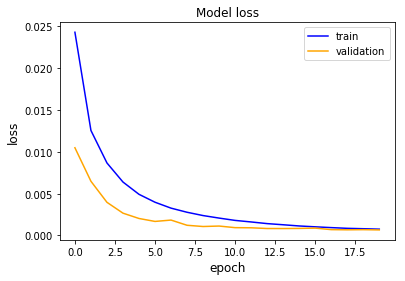

In [19]:
plt.figure()
plt.rcParams["figure.figsize"] = (5,5)
plt.plot(history.history['loss'],color='blue')
plt.plot(history.history['val_loss'],color='orange')
plt.title('Model loss',fontsize=12)
plt.ylabel('loss',fontsize=12)
plt.xlabel('epoch',fontsize=12)
plt.legend(['train', 'validation'])
#plt.savefig('Write_up/model_loss.png')
plt.show()

In [20]:
history.history.keys()

dict_keys(['val_loss', 'val_rmse', 'val_r_square', 'loss', 'rmse', 'r_square'])

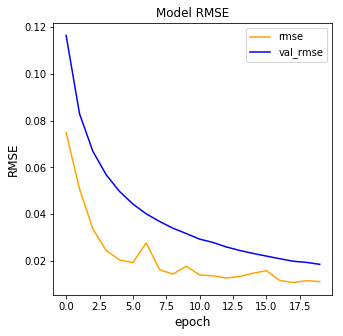

In [21]:
plt.rcParams["figure.figsize"] = (5,5)
plt.plot(history.history['val_rmse'],color='orange')
plt.plot(history.history['rmse'],color='b')
plt.title('Model RMSE',fontsize=12)
plt.ylabel('RMSE',fontsize=12)
plt.xlabel('epoch',fontsize=12)
plt.legend(['train', 'validation'])
plt.savefig('Write_up/RMSE_loss.png')
plt.legend(['rmse', 'val_rmse'], loc='upper right')
#plt.savefig('Write_up/rmse.png')
plt.show()


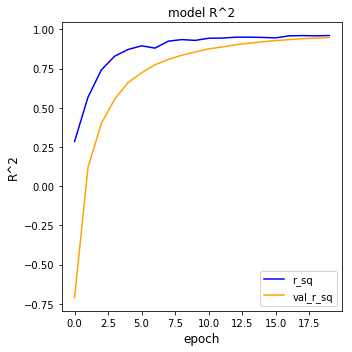

In [22]:
#plt.rcParams["figure.figsize"] = (5,5)
plt.plot(history.history['val_r_square'],color='b')
plt.plot(history.history['r_square'],color='orange')
plt.title('model R^2',fontsize=12)
plt.ylabel('R^2',fontsize=12)
plt.xlabel('epoch',fontsize=12)
plt.legend(['r_sq', 'val_r_sq'], loc='lower right')
plt.tight_layout()
#plt.savefig('Write_up/Rsquared.png')
plt.show()


In [23]:
#have a look at the filter
convlayer = model.layers[0]
weights = convlayer.get_weights()[0].squeeze()
print('Convolution parameter shape: {}'.format(weights.shape))

num2seq = ['A','C','G','T']

#''.join([num2seq[np.argmax(weights[i,:])] for i in range(weights.shape[0])])
#test_pred = ''.join([num2seq[np.argmax(weights[i,:])] for i in range(weights.shape[0])])

Convolution parameter shape: (41, 4, 30)


## Make predictions

In [24]:
model_prediction = model.predict(X_test)

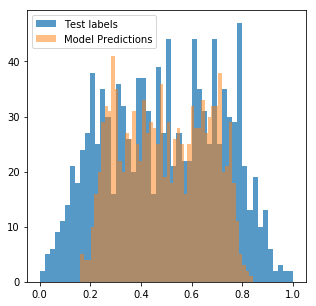

In [25]:
plt.hist(test_pos_labels,bins=50,alpha=0.75,label='Test labels')
plt.hist(model_prediction,bins=50,alpha=0.5,label='Model Predictions')
plt.legend()
plt.show()

In [26]:
pos_model_prediction = model.predict(test_pos_tensor)

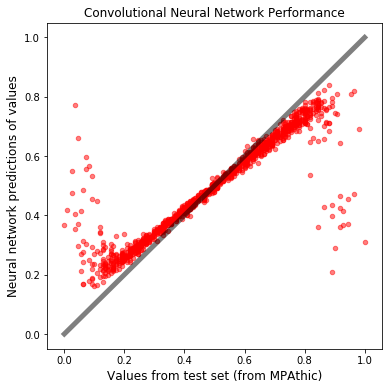

In [27]:
from pylab import rcParams
rcParams['xtick.labelsize'] = 10 
rcParams['ytick.labelsize'] = 10 
rcParams['figure.figsize'] = 6, 6

plt.scatter(y_test,pos_model_prediction,s=20,alpha=0.5,color='red')
plt.plot([0,1],alpha=0.5,linewidth=5,color='black')
plt.ylabel('Neural network predictions of values',fontsize=12)
plt.xlabel('Values from test set (from MPAthic)',fontsize=12)
plt.title('Convolutional Neural Network Performance')
plt.show()


In [28]:
import tensorflow.keras.backend as K
import tensorflow as tf

K.set_session(tf.Session(graph=model.output.graph)) 
init = tf.global_variables_initializer() 
K.get_session().run(init)

def compute_salient_bases(model, x):
  input_tensors = [model.input]
  gradients = model.optimizer.get_gradients(model.output[0][0], model.input)
  
  compute_gradients = K.function(inputs = input_tensors, outputs = gradients)
  x_value = np.expand_dims(x, axis=0)

  gradients = compute_gradients([x_value])[0][0]
  sal = np.clip(np.sum(np.multiply(gradients,x), axis=1),a_min=0, a_max=None)
  return sal


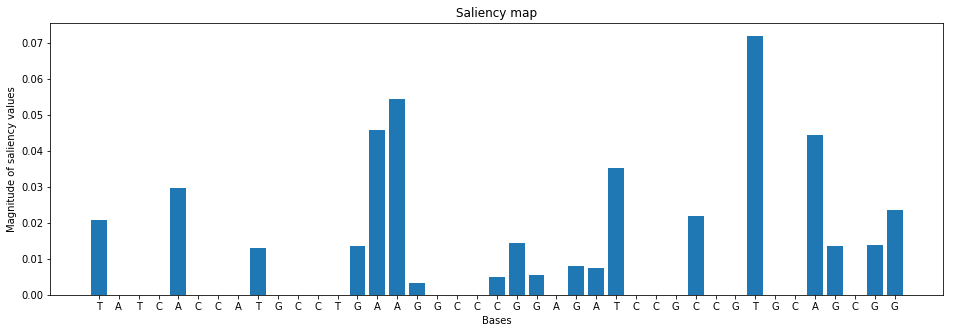

In [29]:
sequence_index = 610
sal = compute_salient_bases(model, X_test[sequence_index])

plt.figure(figsize=[16,5])
barlist = plt.bar(np.arange(len(sal)), sal)
#[barlist[i].set_color('C1') for i in range(5,17)]
plt.xlabel('Bases')
plt.ylabel('Magnitude of saliency values')
plt.xticks(np.arange(len(sal)), list(sequences[sequence_index]));
plt.title('Saliency map');
plt.show()

In [30]:
predict_single_sequence = 610
print(model.predict(X_test[predict_single_sequence:predict_single_sequence+1]))

label_single_sequence = predict_single_sequence
print(test_pos_labels[label_single_sequence:label_single_sequence+1])

[[0.4738013]]
[0.49090909]


In [31]:
model_prediction.argmin()

886

In [32]:
np.shape(pos_model_prediction)

(1154, 1)